In [1]:
!python -m spacy download ro_core_news_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.5/568.5 MB 2.6 MB/s eta 0:00:00:00:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('ro_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Loading spaCy model...
Loading FastText model...
Loading Word2Vec model...
Loading transformer model...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

2025-06-14 19:54:41.116802: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749930881.468137      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749930881.571405      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Loading corola frequency data...
Loading romanian_word_percentages data...
Loading training data...
Processing tokens with spaCy...
Generating linguistic features...
Generating embeddings for training data...
Generating transformer embeddings for training data...


100%|██████████| 1073/1073 [02:00<00:00,  8.92it/s]


Calculating complexity direction...
Loading and processing test data...
Processing test tokens with spaCy...
Generating linguistic features for test data...
Generating embeddings for test data...


100%|██████████| 514/514 [00:49<00:00, 10.48it/s]



RUNNING ENSEMBLE MODELS
Training features shape: (1073, 59)
Test features shape: (514, 59)

=== CatBoost Cross-Validation ===
Fold 1: RMSE=0.1011, R²=0.6175, Pearson=0.7870
Fold 2: RMSE=0.1062, R²=0.6036, Pearson=0.7900
Fold 3: RMSE=0.1188, R²=0.6237, Pearson=0.7951
Fold 4: RMSE=0.1100, R²=0.5359, Pearson=0.7388
Fold 5: RMSE=0.1112, R²=0.6697, Pearson=0.8327
Average RMSE: 0.1095 ± 0.0058
Average R²: 0.6101 ± 0.0432
Average Pearson: 0.7887 ± 0.0299

=== LightGBM Cross-Validation ===
Fold 1: RMSE=0.1003, R²=0.6235, Pearson=0.7921
Fold 2: RMSE=0.1050, R²=0.6126, Pearson=0.7845
Fold 3: RMSE=0.1148, R²=0.6481, Pearson=0.8052
Fold 4: RMSE=0.1111, R²=0.5272, Pearson=0.7290
Fold 5: RMSE=0.1037, R²=0.7127, Pearson=0.8470
Average RMSE: 0.1070 ± 0.0052
Average R²: 0.6248 ± 0.0599
Average Pearson: 0.7915 ± 0.0380

=== Model Comparison ===
      Model  Mean_RMSE  Std_RMSE   Mean_R2    Std_R2  Mean_Pearson  \
0  CatBoost   0.109466  0.005828  0.610079  0.043225      0.788743   
1  LightGBM   0.1069

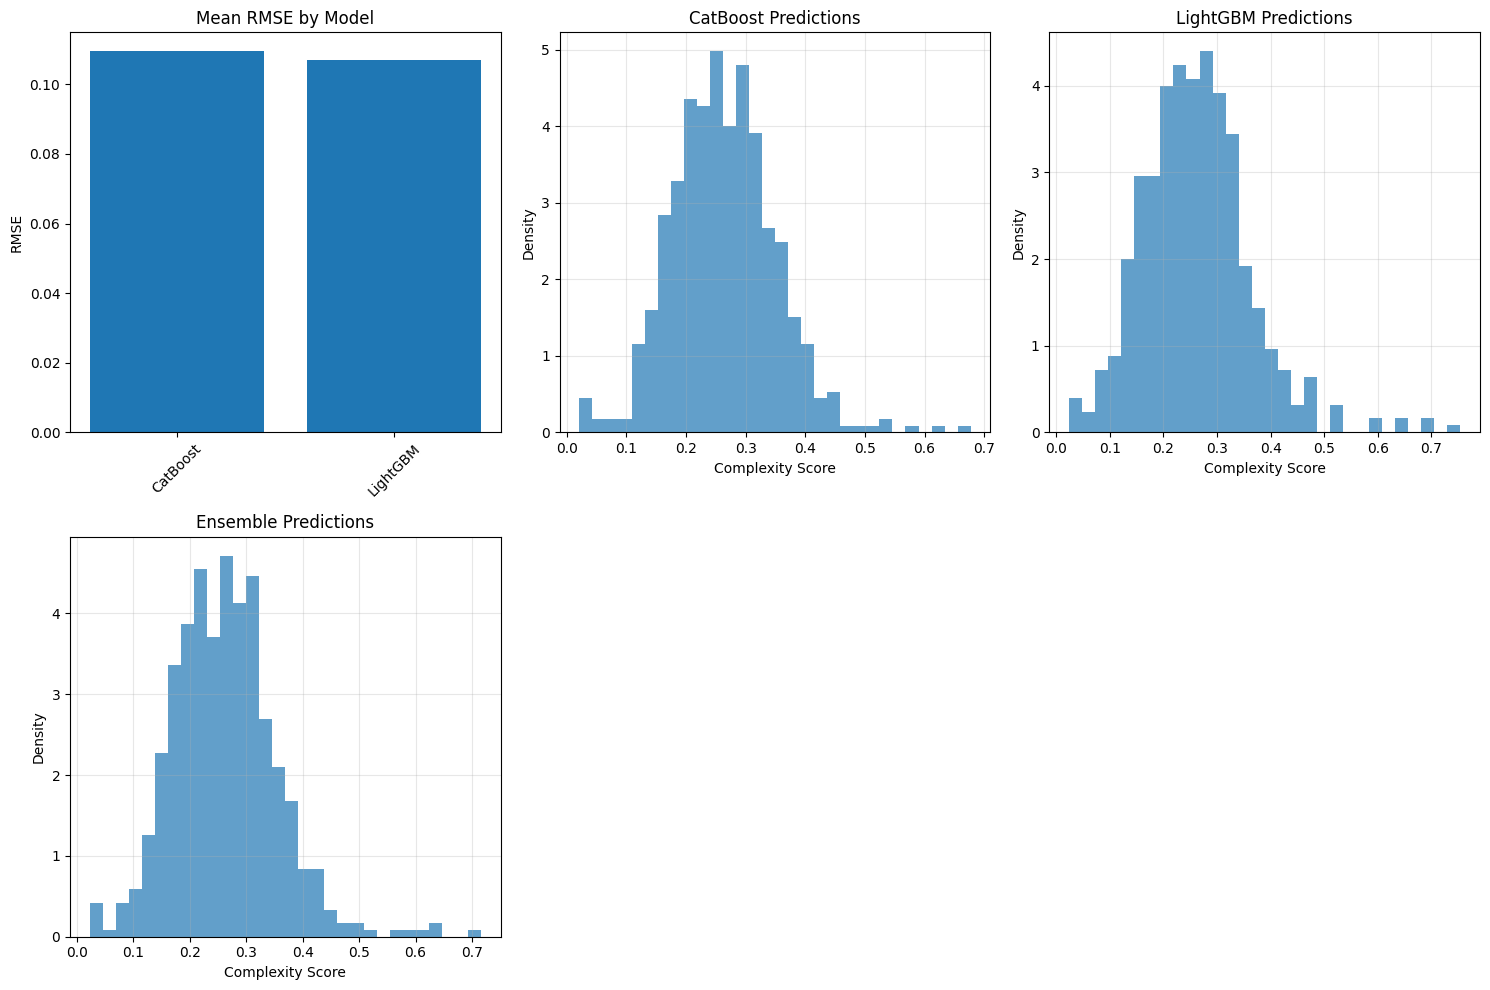

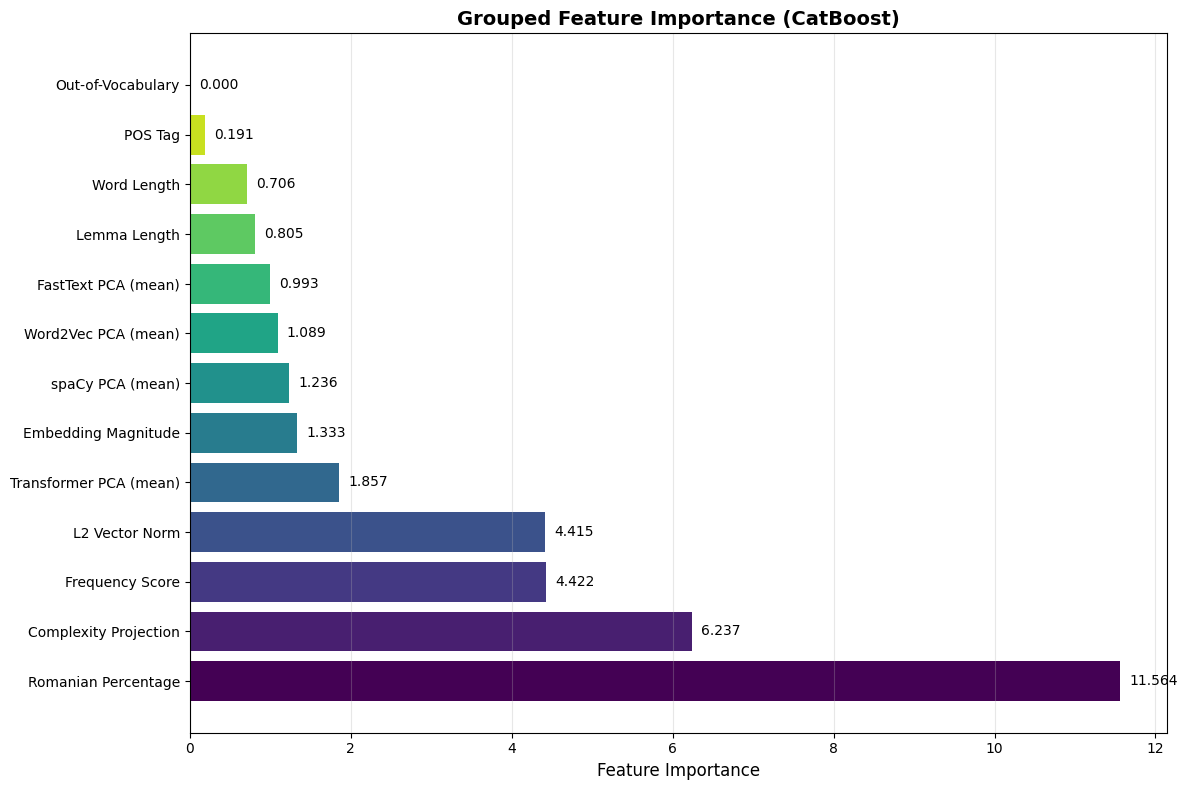


Grouped Feature Importance:
----------------------------------------
Romanian Percentage      : 11.5641
Complexity Projection    : 6.2373
Frequency Score          : 4.4223
L2 Vector Norm           : 4.4153
Transformer PCA (mean)   : 1.8571
Embedding Magnitude      : 1.3328
spaCy PCA (mean)         : 1.2362
Word2Vec PCA (mean)      : 1.0893
FastText PCA (mean)      : 0.9930
Lemma Length             : 0.8046
Word Length              : 0.7057
POS Tag                  : 0.1909
Out-of-Vocabulary        : 0.0002

ENSEMBLE MODELING COMPLETE

Files generated:
- submission_catboost_wikipedia.csv
- submission_lightgbm_wikipedia.csv
- submission_ensemble_wikipedia.csv
- ensemble_model_analysis.png
- grouped_feature_importance.png


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from gensim.models.fasttext import load_facebook_vectors
from gensim.models import Word2Vec
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
import spacy
import fasttext
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import torch
import math

# Gradient Boosting Models
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Load spaCy model
print("Loading spaCy model...")
nlp = spacy.load("ro_core_news_lg")

# Load FastText model
print("Loading FastText model...")
fasttext_model = fasttext.load_model('/kaggle/input/complexity-direction-in-space/cc.ro.300.bin')

# Load Word2Vec model
print("Loading Word2Vec model...")
word2vec_model = Word2Vec.load('/kaggle/input/word2vec/SG_300_25_15.model')

# Load transformer model
print("Loading transformer model...")
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
transformer_model = AutoModel.from_pretrained(model_name)
transformer_model.eval()

# Load corola frequency data
print("Loading corola frequency data...")
corola_data = pd.read_csv('/kaggle/input/column-corola/corola.csv')

print("Loading romanian_word_percentages data...")
rom_freq_data = pd.read_csv('/kaggle/input/wikipedia-scrape/romanian_word_percentages.csv')
rom_freq_data.rename(columns={'word': 'token'}, inplace=True)

def get_rom_percentage_score(df, rom_freq_data):
    scores = []
    for _, row in df.iterrows():
        lemma = row['val_token'][0].lemma_.lower()
        match = rom_freq_data.loc[rom_freq_data['token'] == lemma]
        if not match.empty:
            scores.append(float(match['percentage'].values[0]))  # or 'rank' if you prefer
        else:
            scores.append(0.0)  # OOV fallback
    return scores


def get_token_embedding(sentence, token, tokenizer, model):
    inputs = tokenizer(sentence, return_tensors="pt", return_offsets_mapping=True)
    offset_mapping = inputs.pop("offset_mapping")[0]
    
    start_char = sentence.find(token)
    end_char = start_char + len(token)
    
    token_indices = [
        i for i, (start, end) in enumerate(offset_mapping)
        if start >= start_char and end <= end_char
    ]

    if not token_indices:
        return None

    with torch.no_grad():
        output = model(**inputs)
        hidden_states = output.last_hidden_state

    embeddings = hidden_states[0, token_indices, :]
    return embeddings.mean(dim=0).numpy()

def avg_token_freq_score(df, corola_data):
    x_values = []
    count_words_corola = corola_data['frequency'].sum()
    for _, row in df.iterrows():
        for token_val in row['val_token']:
            lemma = token_val.lemma_.lower()
            frequency = corola_data.loc[corola_data["token"] == lemma, "frequency"]
            if not frequency.empty:
                x_values.append(-math.log(frequency.values[0] / count_words_corola))
            else:
                x_values.append(9.6967059641)  # Default value for OOV
    return x_values

def l2_vector_norm(df):
    norm = []
    for row in df['val_token']:
        text = row[0]
        norm.append(text.vector_norm)
    return norm

def pos_token(df):
    x_values = []
    for row in df['val_token']:
        c = 0
        text = row[0]
        if text.pos_ == 'X' or text.pos_ == 'PROPN':
            c = 1
        x_values.append(c)
    return x_values

def len_lemma_token(df):
    x_values = []
    for _, row in df.iterrows():
        for token_val in row['val_token']:
            lemma = token_val.lemma_.lower()
            x_values.append(len(lemma))
    return x_values

def oov(df):
    l = []
    for row in df['val_token']:
        text = row[0]
        if text.is_oov:
            l.append(1)
        else:
            l.append(0)
    return l

def get_word2vec_embedding(token, model):
    try:
        return model.wv[token]
    except KeyError:
        return np.zeros(model.wv.vector_size)

def get_tensor_column(df, column_name, expected_dim):
    """Convert dataframe column to tensor with proper dimensions"""
    data = []
    for item in df[column_name]:
        if isinstance(item, (list, np.ndarray)):
            if len(item) == expected_dim:
                data.append(item)
            else:
                data.append(np.zeros(expected_dim))
        else:
            if expected_dim == 1:
                data.append([item])
            else:
                data.append(np.zeros(expected_dim))
    return torch.tensor(np.array(data), dtype=torch.float32)

def prepare_features_ensemble(df):
    """Prepare features for ensemble models (CatBoost, XGBoost, LightGBM)"""
    # Basic linguistic features
    oov_feat = np.array(df['oov'].values).reshape(-1, 1)
    len_lemma_feat = np.array(df['len_lemma_token'].values).reshape(-1, 1)
    pos_feat = np.array(df['pos_token'].values).reshape(-1, 1)
    l2_norm_feat = np.array(df['l2_vector_norm'].values).reshape(-1, 1)
    freq_score_feat = np.array(df['avg_token_freq_score'].values).reshape(-1, 1)
    rom_percentage_feat = np.array(df['rom_percentage_score'].values).reshape(-1, 1)
    
    # Embedding features
    word2vec_embeddings = np.vstack(df['word2vec_embedding'].values)
    fasttext_embeddings = np.vstack(df['fasttext_embedding'].values)
    spacy_embeddings = np.vstack(df['spacy_embedding'].values)
    transformer_embeddings = np.vstack(df['hf_transformer_embedding'].values)
    
    # Complexity projection (using FastText)
    complexity_projections = fasttext_embeddings.dot(complexity_direction).reshape(-1, 1)
    
    # Word length and embedding magnitude
    word_lengths = np.array([len(token) for token in df['token']]).reshape(-1, 1)
    embedding_magnitudes = np.array([np.linalg.norm(emb) for emb in fasttext_embeddings]).reshape(-1, 1)
    
    # Apply PCA to reduce embedding dimensions
    pca_components = 10
    
    # Use existing PCA or create new ones
    if not hasattr(prepare_features_ensemble, 'pca_fitted'):
        prepare_features_ensemble.pca_word2vec = PCA(n_components=pca_components)
        prepare_features_ensemble.pca_fasttext = PCA(n_components=pca_components)
        prepare_features_ensemble.pca_spacy = PCA(n_components=pca_components)
        prepare_features_ensemble.pca_transformer = PCA(n_components=20)
        
        word2vec_pca = prepare_features_ensemble.pca_word2vec.fit_transform(word2vec_embeddings)
        fasttext_pca = prepare_features_ensemble.pca_fasttext.fit_transform(fasttext_embeddings)
        spacy_pca = prepare_features_ensemble.pca_spacy.fit_transform(spacy_embeddings)
        transformer_pca = prepare_features_ensemble.pca_transformer.fit_transform(transformer_embeddings)
        
        prepare_features_ensemble.pca_fitted = True
    else:
        word2vec_pca = prepare_features_ensemble.pca_word2vec.transform(word2vec_embeddings)
        fasttext_pca = prepare_features_ensemble.pca_fasttext.transform(fasttext_embeddings)
        spacy_pca = prepare_features_ensemble.pca_spacy.transform(spacy_embeddings)
        transformer_pca = prepare_features_ensemble.pca_transformer.transform(transformer_embeddings)
    
    # Combine all features
    X = np.column_stack([
        complexity_projections,      # 1 feature
        word_lengths,               # 1 feature
        embedding_magnitudes,       # 1 feature
        oov_feat,                  # 1 feature
        len_lemma_feat,            # 1 feature
        pos_feat,                  # 1 feature
        l2_norm_feat,              # 1 feature
        freq_score_feat,           # 1 feature
        rom_percentage_feat, # 1 feature
        word2vec_pca,              # 10 features
        fasttext_pca,              # 10 features
        spacy_pca,                 # 10 features
        transformer_pca            # 20 features
    ])
    
    return X

def plot_grouped_feature_importance(feature_importance):
    """Plot feature importance with grouped PCA components"""
    
    # Define feature groups and their indices
    feature_groups = {
        'Complexity Projection': [0],
        'Word Length': [1],
        'Embedding Magnitude': [2],
        'Out-of-Vocabulary': [3],
        'Lemma Length': [4],
        'POS Tag': [5],
        'L2 Vector Norm': [6],
        'Frequency Score': [7],
        'Romanian Percentage': [8],
        'Word2Vec PCA (mean)': list(range(9, 19)),
        'FastText PCA (mean)': list(range(19, 29)),
        'spaCy PCA (mean)': list(range(29, 39)),
        'Transformer PCA (mean)': list(range(39, 59))
    }
    
    # Calculate grouped importance scores
    grouped_importance = {}
    for group_name, indices in feature_groups.items():
        if len(indices) == 1:
            # Single feature groups
            grouped_importance[group_name] = feature_importance[indices[0]]
        else:
            # PCA groups - take the mean
            grouped_importance[group_name] = np.mean(feature_importance[indices])
    
    # Sort by importance
    sorted_groups = sorted(grouped_importance.items(), key=lambda x: x[1], reverse=True)
    group_names = [item[0] for item in sorted_groups]
    importance_values = [item[1] for item in sorted_groups]
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, len(group_names)))
    bars = plt.barh(range(len(group_names)), importance_values, color=colors)
    
    # Customize the plot
    plt.yticks(range(len(group_names)), group_names)
    plt.xlabel('Feature Importance', fontsize=12)
    plt.title('Grouped Feature Importance (CatBoost)', fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, value) in enumerate(zip(bars, importance_values)):
        plt.text(value + max(importance_values) * 0.01, i, f'{value:.3f}', 
                va='center', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('grouped_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print the grouped importance values
    print("\nGrouped Feature Importance:")
    print("-" * 40)
    for group_name, importance in sorted_groups:
        print(f"{group_name:<25}: {importance:.4f}")
    
    return grouped_importance

def run_ensemble_models(train_df, test_df, use_cv=True, n_folds=5):
    """Run ensemble of gradient boosting models with cross-validation"""
    
    # Prepare training features
    X_train = prepare_features_ensemble(train_df)
    y_train = train_df['score'].values
    
    # Prepare test features
    X_test = prepare_features_ensemble(test_df)
    
    print(f"Training features shape: {X_train.shape}")
    print(f"Test features shape: {X_test.shape}")
    
    # Define models with optimized hyperparameters
    models = {
        'CatBoost': CatBoostRegressor(
            iterations=1000,
            learning_rate=0.1,
            depth=8,
            l2_leaf_reg=3,
            loss_function='RMSE',
            eval_metric='RMSE',
            random_seed=42,
            verbose=False,
            early_stopping_rounds=100
        ),
        'LightGBM': LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.1,
            max_depth=8,
            reg_alpha=0.1,
            reg_lambda=1,
            objective='regression',
            random_state=42,
            verbose=-1,
            early_stopping_round=100
        )
    }
    
    results = []
    predictions = {}
    
    if use_cv:
        kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
        
        for model_name, model in models.items():
            print(f"\n=== {model_name} Cross-Validation ===")
            
            cv_scores = []
            cv_r2_scores = []
            cv_pearson_scores = []
            fold_predictions = []
            
            for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
                X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
                y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
                
                # Fit model
                if model_name in ['CatBoost', 'XGBoost']:
                    model.fit(X_fold_train, y_fold_train, 
                             eval_set=[(X_fold_val, y_fold_val)], 
                             verbose=False)
                else:  # LightGBM
                    model.fit(X_fold_train, y_fold_train, 
                             eval_set=[(X_fold_val, y_fold_val)])
                
                # Make predictions
                val_pred = model.predict(X_fold_val)
                val_pred = np.clip(val_pred, 0, 1)  # Ensure predictions are in [0,1] range
                
                # Calculate metrics
                rmse = np.sqrt(mean_squared_error(y_fold_val, val_pred))
                r2 = r2_score(y_fold_val, val_pred)
                pearson = pearsonr(y_fold_val, val_pred)[0]
                
                cv_scores.append(rmse)
                cv_r2_scores.append(r2)
                cv_pearson_scores.append(pearson)
                
                print(f"Fold {fold+1}: RMSE={rmse:.4f}, R²={r2:.4f}, Pearson={pearson:.4f}")
                
                # Test predictions for this fold
                test_pred = model.predict(X_test)
                test_pred = np.clip(test_pred, 0, 1)
                fold_predictions.append(test_pred)
            
            # Average test predictions across folds
            avg_test_pred = np.mean(fold_predictions, axis=0)
            predictions[model_name] = avg_test_pred
            
            # Store results
            results.append({
                'Model': model_name,
                'Mean_RMSE': np.mean(cv_scores),
                'Std_RMSE': np.std(cv_scores),
                'Mean_R2': np.mean(cv_r2_scores),
                'Std_R2': np.std(cv_r2_scores),
                'Mean_Pearson': np.mean(cv_pearson_scores),
                'Std_Pearson': np.std(cv_pearson_scores)
            })
            
            print(f"Average RMSE: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
            print(f"Average R²: {np.mean(cv_r2_scores):.4f} ± {np.std(cv_r2_scores):.4f}")
            print(f"Average Pearson: {np.mean(cv_pearson_scores):.4f} ± {np.std(cv_pearson_scores):.4f}")
    
    else:
        # Simple train/validation split
        X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
        
        for model_name, model in models.items():
            print(f"\n=== Training {model_name} ===")
            
            # Fit model
            if model_name in ['CatBoost', 'XGBoost']:
                model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
            else:  # LightGBM
                model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])
            
            # Validation predictions
            val_pred = model.predict(X_val)
            val_pred = np.clip(val_pred, 0, 1)
            
            # Calculate metrics
            rmse = np.sqrt(mean_squared_error(y_val, val_pred))
            r2 = r2_score(y_val, val_pred)
            pearson = pearsonr(y_val, val_pred)[0]
            
            print(f"Validation RMSE: {rmse:.4f}")
            print(f"Validation R²: {r2:.4f}")
            print(f"Validation Pearson: {pearson:.4f}")
            
            # Test predictions
            test_pred = model.predict(X_test)
            test_pred = np.clip(test_pred, 0, 1)
            predictions[model_name] = test_pred
            
            results.append({
                'Model': model_name,
                'RMSE': rmse,
                'R2': r2,
                'Pearson': pearson
            })
    
    # Create ensemble prediction (average of all models)
    ensemble_pred = np.mean(list(predictions.values()), axis=0)
    predictions['Ensemble'] = ensemble_pred
    
    # Display results
    results_df = pd.DataFrame(results)
    print("\n=== Model Comparison ===")
    print(results_df)
    
    return predictions, results_df

# Load and prepare training data
print("Loading training data...")
train_set = pd.read_csv('/kaggle/input/predictia-complexitatii-cuvintelor-2025/train.csv')

# Process tokens with spaCy
print("Processing tokens with spaCy...")
train_set['val_token'] = train_set['token'].apply(nlp)

# Generate linguistic features
print("Generating linguistic features...")
train_set['oov'] = oov(train_set)
train_set['len_lemma_token'] = len_lemma_token(train_set)
train_set['pos_token'] = pos_token(train_set)
train_set['l2_vector_norm'] = l2_vector_norm(train_set)
train_set['avg_token_freq_score'] = avg_token_freq_score(train_set, corola_data)

# Generate embeddings for training data
print("Generating embeddings for training data...")
train_set['spacy_embedding'] = train_set['token'].apply(lambda token: nlp(token).vector)
train_set['fasttext_embedding'] = train_set['token'].apply(lambda token: fasttext_model.get_word_vector(token))
train_set['word2vec_embedding'] = train_set['token'].apply(lambda token: get_word2vec_embedding(token, word2vec_model))

print("Generating transformer embeddings for training data...")
train_embeddings = []
for _, row in tqdm(train_set.iterrows(), total=len(train_set)):
    emb = get_token_embedding(row['sentence'], row['token'], tokenizer, transformer_model)
    train_embeddings.append(emb if emb is not None else np.zeros(768))
train_set['hf_transformer_embedding'] = train_embeddings
train_set['rom_percentage_score'] = get_rom_percentage_score(train_set, rom_freq_data)


# Calculate complexity direction from simple-complex pairs
print("Calculating complexity direction...")
simple_complex_pairs_dataframe = pd.read_csv('/kaggle/input/simple-complex-1k/simple_complex_pairs_1k.csv')
simple_complex_pairs_dataframe['complex'] = simple_complex_pairs_dataframe['complex'].apply(str.strip)
simple_complex_pairs = simple_complex_pairs_dataframe[['simple', 'complex']].values

diff_vectors_complex_to_simple = []
for simple_word, complex_word in simple_complex_pairs:
    try:
        vec_simple = fasttext_model.get_word_vector(simple_word)
        vec_complex = fasttext_model.get_word_vector(complex_word)
        diff_complex_to_simple = vec_simple - vec_complex
        diff_vectors_complex_to_simple.append(diff_complex_to_simple)
    except:
        continue

diff_matrix = np.vstack(diff_vectors_complex_to_simple)
complexity_direction = np.mean(diff_matrix, axis=0)
complexity_direction = complexity_direction / np.linalg.norm(complexity_direction)

# Load and process test data
print("Loading and processing test data...")
test_set = pd.read_csv('/kaggle/input/predictia-complexitatii-cuvintelor-2025/test.csv')

# Process test tokens with spaCy
print("Processing test tokens with spaCy...")
test_set['val_token'] = test_set['token'].apply(nlp)

# Generate linguistic features for test data
print("Generating linguistic features for test data...")
test_set['oov'] = oov(test_set)
test_set['len_lemma_token'] = len_lemma_token(test_set)
test_set['pos_token'] = pos_token(test_set)
test_set['l2_vector_norm'] = l2_vector_norm(test_set)
test_set['avg_token_freq_score'] = avg_token_freq_score(test_set, corola_data)

# Generate embeddings for test data
print("Generating embeddings for test data...")
test_set['spacy_embedding'] = test_set['token'].apply(lambda token: nlp(token).vector)
test_set['fasttext_embedding'] = test_set['token'].apply(lambda token: fasttext_model.get_word_vector(token))
test_set['word2vec_embedding'] = test_set['token'].apply(lambda token: get_word2vec_embedding(token, word2vec_model))

test_embeddings = []
for _, row in tqdm(test_set.iterrows(), total=len(test_set)):
    emb = get_token_embedding(row['sentence'], row['token'], tokenizer, transformer_model)
    test_embeddings.append(emb if emb is not None else np.zeros(768))
test_set['hf_transformer_embedding'] = test_embeddings
test_set['rom_percentage_score'] = get_rom_percentage_score(test_set, rom_freq_data)

# Run ensemble models
print("\n" + "="*50)
print("RUNNING ENSEMBLE MODELS")
print("="*50)

predictions, results_df = run_ensemble_models(train_set, test_set, use_cv=True, n_folds=5)

# Create submissions for each model
for model_name, preds in predictions.items():
    submission_df = pd.DataFrame({
        'Id': test_set['Id'].tolist(),
        'complexity': preds
    })
    
    filename = f'submission_{model_name.lower()}_wikipedia.csv'
    submission_df.to_csv(filename, index=False)
    
    print(f"\n{model_name} Submission Stats:")
    print(f"Shape: {submission_df.shape}")
    print(f"Complexity range: {submission_df['complexity'].min():.3f} - {submission_df['complexity'].max():.3f}")
    print(f"Mean complexity: {submission_df['complexity'].mean():.3f}")
    print(f"Saved as: {filename}")

# Visualize predictions
plt.figure(figsize=(15, 10))

# Plot 1: Model comparison
plt.subplot(2, 3, 1)
if 'Mean_RMSE' in results_df.columns:
    plt.bar(results_df['Model'], results_df['Mean_RMSE'])
    plt.title('Mean RMSE by Model')
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
else:
    plt.bar(results_df['Model'], results_df['RMSE'])
    plt.title('RMSE by Model')
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)

# Plot 2: Prediction distributions
for i, (model_name, preds) in enumerate(predictions.items()):
    plt.subplot(2, 3, i+2)
    plt.hist(preds, bins=30, alpha=0.7, density=True)
    plt.title(f'{model_name} Predictions')
    plt.xlabel('Complexity Score')
    plt.ylabel('Density')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ensemble_model_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Generate grouped feature importance plot
try:
    # Retrain CatBoost to get feature importance
    catboost_model = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.1,
        depth=8,
        l2_leaf_reg=3,
        loss_function='RMSE',
        random_seed=42,
        verbose=False
    )
    
    X_train = prepare_features_ensemble(train_set)
    y_train = train_set['score'].values
    
    catboost_model.fit(X_train, y_train)
    
    feature_importance = catboost_model.get_feature_importance()
    
    # Plot grouped feature importance
    grouped_importance = plot_grouped_feature_importance(feature_importance)
    
except Exception as e:
    print(f"Could not generate feature importance: {e}")

print("\n" + "="*50)
print("ENSEMBLE MODELING COMPLETE")
print("="*50)
print("\nFiles generated:")
for model_name in predictions.keys():
    print(f"- submission_{model_name.lower()}_wikipedia.csv")
print("- ensemble_model_analysis.png")
print("- grouped_feature_importance.png")

Training CatBoost for feature importance...
Training LightGBM for feature importance...


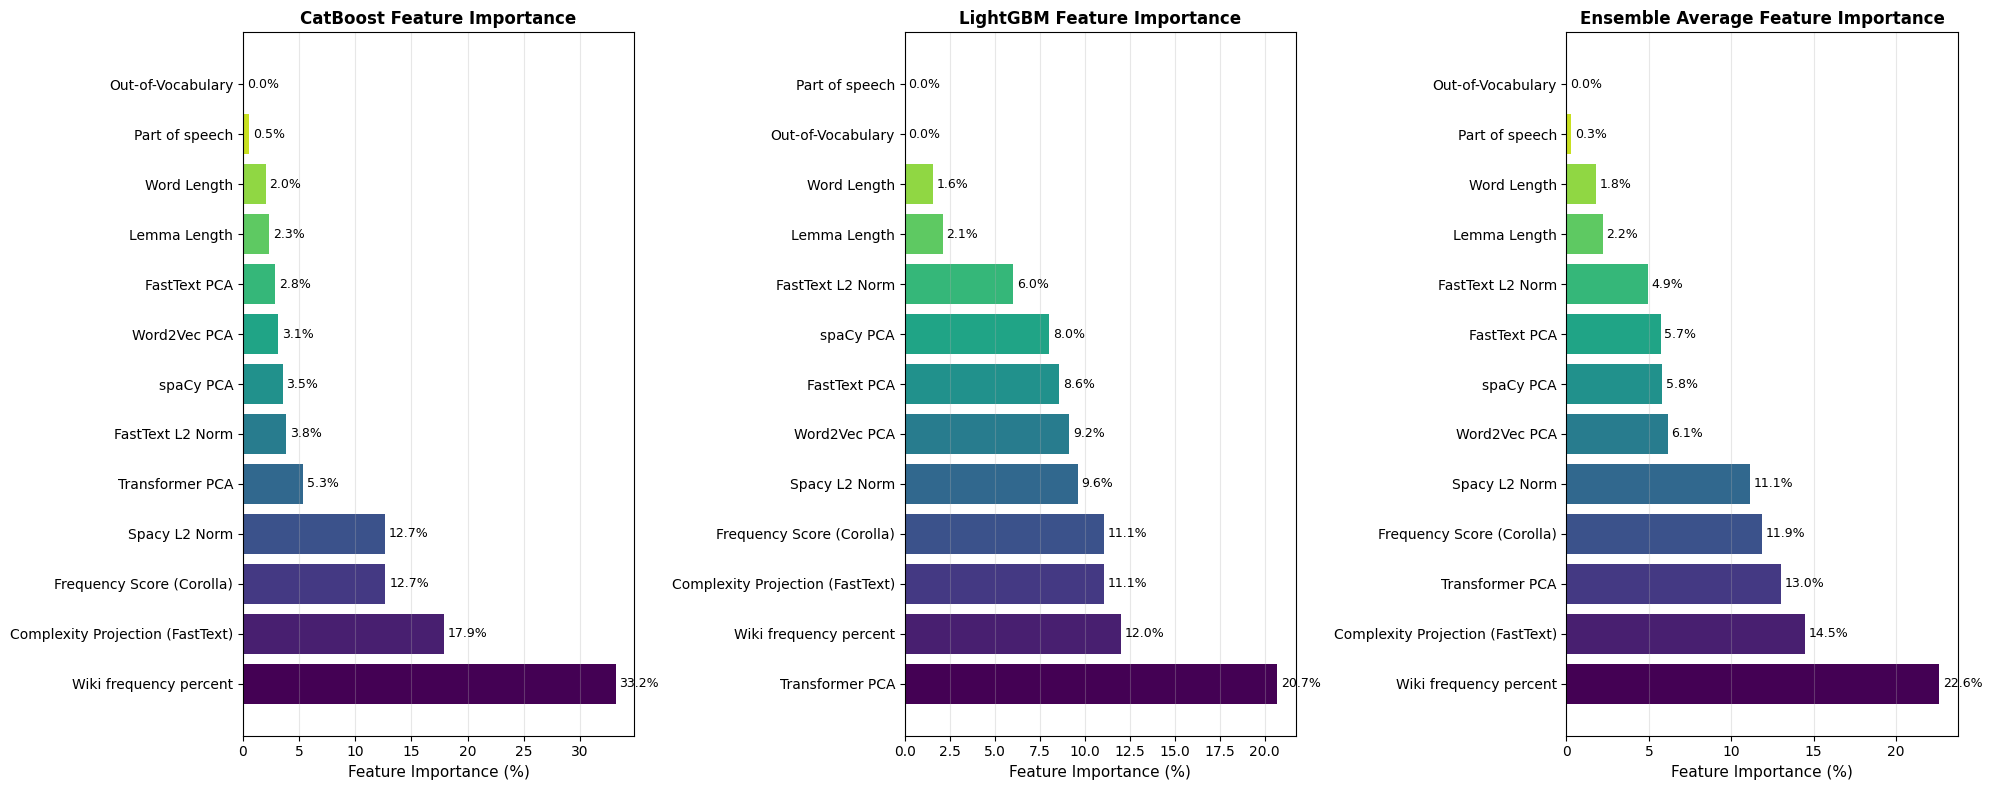


DETAILED FEATURE IMPORTANCE ANALYSIS

CatBoost Feature Importance:
--------------------------------------------------
Wiki frequency percent   : 33.18%
Complexity Projection (FastText): 17.90%
Frequency Score (Corolla): 12.69%
Spacy L2 Norm            : 12.67%
Transformer PCA          : 5.33%
FastText L2 Norm         : 3.82%
spaCy PCA                : 3.55%
Word2Vec PCA             : 3.13%
FastText PCA             : 2.85%
Lemma Length             : 2.31%
Word Length              : 2.03%
Part of speech           : 0.55%
Out-of-Vocabulary        : 0.00%

LightGBM Feature Importance:
--------------------------------------------------
Transformer PCA          : 20.71%
Wiki frequency percent   : 12.03%
Complexity Projection (FastText): 11.08%
Frequency Score (Corolla): 11.08%
Spacy L2 Norm            : 9.61%
Word2Vec PCA             : 9.15%
FastText PCA             : 8.57%
spaCy PCA                : 8.04%
FastText L2 Norm         : 6.02%
Lemma Length             : 2.11%
Word Length        

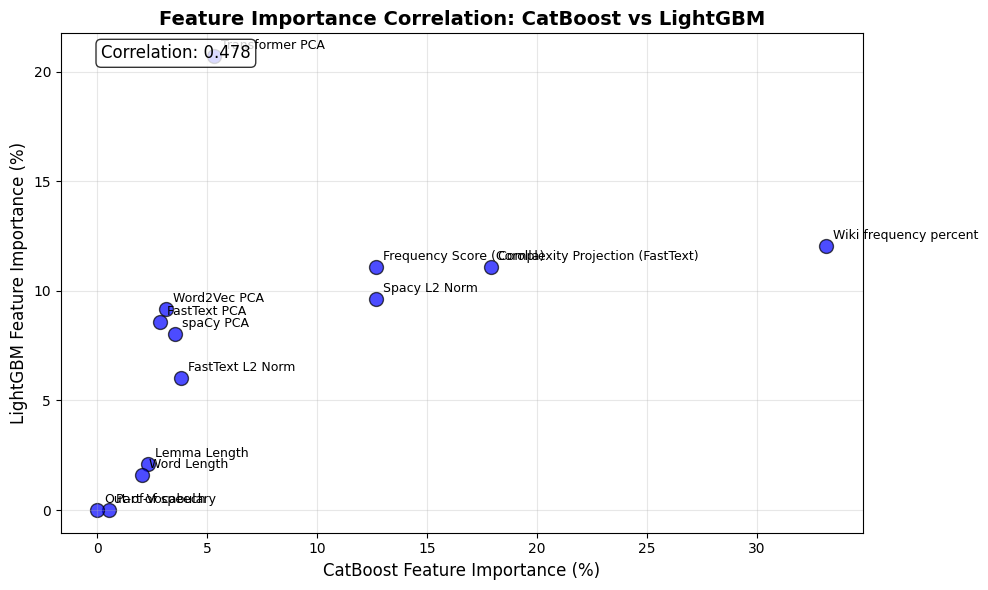


FEATURE IMPORTANCE ANALYSIS COMPLETE

Files generated:
- comprehensive_feature_importance.png
- feature_importance_correlation.png


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

def plot_grouped_feature_importance_comprehensive(train_set, create_ensemble_plot=True):
    """
    Create comprehensive feature importance plots for CatBoost, LightGBM, and Ensemble
    """
    
    # Prepare training data
    X_train = prepare_features_ensemble(train_set)
    y_train = train_set['score'].values
    
    # Define feature groups and their indices
    feature_groups = {
        'Complexity Projection (FastText)': [0],
        'Word Length': [1],
        'FastText L2 Norm': [2],
        'Out-of-Vocabulary': [3],
        'Lemma Length': [4],
        'Part of speech': [5],
        'Spacy L2 Norm': [6],
        'Frequency Score (Corolla)': [7],
        'Wiki frequency percent': [8],
        'Word2Vec PCA': list(range(9, 19)),
        'FastText PCA': list(range(19, 29)),
        'spaCy PCA': list(range(29, 39)),
        'Transformer PCA': list(range(39, 59))
    }
    
    def get_grouped_importance(feature_importance):
        """Calculate grouped importance scores as percentages"""
        grouped_importance = {}
        for group_name, indices in feature_groups.items():
            if len(indices) == 1:
                # Single feature groups
                grouped_importance[group_name] = feature_importance[indices[0]]
            else:
                # PCA groups - take the mean
                grouped_importance[group_name] = np.mean(feature_importance[indices])
        
        # Convert to percentages
        total_importance = sum(grouped_importance.values())
        for group_name in grouped_importance:
            grouped_importance[group_name] = (grouped_importance[group_name] / total_importance) * 100
        
        return grouped_importance
    
    def plot_single_model_importance(importance_dict, model_name, subplot_pos):
        """Plot importance for a single model"""
        # Sort by importance
        sorted_groups = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
        group_names = [item[0] for item in sorted_groups]
        importance_values = [item[1] for item in sorted_groups]
        
        # Create subplot
        plt.subplot(1, 3, subplot_pos)
        
        # Color scheme
        colors = plt.cm.viridis(np.linspace(0, 1, len(group_names)))
        bars = plt.barh(range(len(group_names)), importance_values, color=colors)
        
        # Customize the plot
        plt.yticks(range(len(group_names)), group_names, fontsize=10)
        plt.xlabel('Feature Importance (%)', fontsize=11)
        plt.title(f'{model_name} Feature Importance', fontsize=12, fontweight='bold')
        plt.grid(axis='x', alpha=0.3)
        
        # Add value labels on bars
        max_val = max(importance_values)
        for i, (bar, value) in enumerate(zip(bars, importance_values)):
            plt.text(value + max_val * 0.01, i, f'{value:.1f}%', 
                    va='center', fontsize=9)
        
        return sorted_groups
    
    # Initialize models
    catboost_model = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.1,
        depth=8,
        l2_leaf_reg=3,
        loss_function='RMSE',
        random_seed=42,
        verbose=False
    )
    
    lightgbm_model = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.1,
        max_depth=8,
        reg_alpha=0.1,
        reg_lambda=1,
        objective='regression',
        random_state=42,
        verbose=-1
    )
    
    # Train models and get feature importance
    print("Training CatBoost for feature importance...")
    catboost_model.fit(X_train, y_train)
    catboost_importance = catboost_model.get_feature_importance()
    catboost_grouped = get_grouped_importance(catboost_importance)
    
    print("Training LightGBM for feature importance...")
    lightgbm_model.fit(X_train, y_train)
    lightgbm_importance = lightgbm_model.feature_importances_
    lightgbm_grouped = get_grouped_importance(lightgbm_importance)
    
    # Create the comprehensive plot
    plt.figure(figsize=(20, 8))
    
    # Plot individual models
    catboost_sorted = plot_single_model_importance(catboost_grouped, 'CatBoost', 1)
    lightgbm_sorted = plot_single_model_importance(lightgbm_grouped, 'LightGBM', 2)
    
    # Create ensemble importance (average of both models)
    if create_ensemble_plot:
        ensemble_importance = {}
        all_features = set(catboost_grouped.keys()) | set(lightgbm_grouped.keys())
        
        for feature in all_features:
            catboost_val = catboost_grouped.get(feature, 0)
            lightgbm_val = lightgbm_grouped.get(feature, 0)
            ensemble_importance[feature] = (catboost_val + lightgbm_val) / 2
        
        ensemble_sorted = plot_single_model_importance(ensemble_importance, 'Ensemble Average', 3)
    
    plt.tight_layout()
    plt.savefig('comprehensive_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print detailed results
    print("\n" + "="*80)
    print("DETAILED FEATURE IMPORTANCE ANALYSIS")
    print("="*80)
    
    print("\nCatBoost Feature Importance:")
    print("-" * 50)
    for feature, importance in catboost_sorted:
        print(f"{feature:<25}: {importance:.2f}%")
    
    print("\nLightGBM Feature Importance:")
    print("-" * 50)
    for feature, importance in lightgbm_sorted:
        print(f"{feature:<25}: {importance:.2f}%")
    
    if create_ensemble_plot:
        print("\nEnsemble Average Feature Importance:")
        print("-" * 50)
        for feature, importance in ensemble_sorted:
            print(f"{feature:<25}: {importance:.2f}%")
    
    # Create comparison dataframe
    comparison_df = pd.DataFrame({
        'Feature': list(catboost_grouped.keys()),
        'CatBoost': [catboost_grouped[f] for f in catboost_grouped.keys()],
        'LightGBM': [lightgbm_grouped[f] for f in catboost_grouped.keys()]
    })
    
    if create_ensemble_plot:
        comparison_df['Ensemble'] = [ensemble_importance[f] for f in catboost_grouped.keys()]
    
    # Sort by ensemble importance if available, otherwise by CatBoost
    sort_column = 'Ensemble' if create_ensemble_plot else 'CatBoost'
    comparison_df = comparison_df.sort_values(sort_column, ascending=False)
    
    print("\nFeature Importance Comparison:")
    print("-" * 70)
    print(comparison_df.to_string(index=False, float_format='%.2f'))
    
    # Create correlation plot between model importances
    plt.figure(figsize=(10, 6))
    plt.scatter(comparison_df['CatBoost'], comparison_df['LightGBM'], 
                alpha=0.7, s=100, c='blue', edgecolors='black')
    
    # Add feature labels
    for i, feature in enumerate(comparison_df['Feature']):
        plt.annotate(feature, 
                    (comparison_df['CatBoost'].iloc[i], comparison_df['LightGBM'].iloc[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    plt.xlabel('CatBoost Feature Importance (%)', fontsize=12)
    plt.ylabel('LightGBM Feature Importance (%)', fontsize=12)
    plt.title('Feature Importance Correlation: CatBoost vs LightGBM', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Add correlation coefficient
    correlation = np.corrcoef(comparison_df['CatBoost'], comparison_df['LightGBM'])[0, 1]
    plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
             transform=plt.gca().transAxes, fontsize=12, 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('feature_importance_correlation.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return comparison_df, catboost_grouped, lightgbm_grouped

# Call the function (assuming train_set is available)
try:
    comparison_df, catboost_importance, lightgbm_importance = plot_grouped_feature_importance_comprehensive(train_set)
    
    print("\n" + "="*50)
    print("FEATURE IMPORTANCE ANALYSIS COMPLETE")
    print("="*50)
    print("\nFiles generated:")
    print("- comprehensive_feature_importance.png")
    print("- feature_importance_correlation.png")
    
except NameError as e:
    print(f"Error: {e}")
    print("Make sure the original code has been run first to create the train_set and prepare_features_ensemble function.")